# 🧠 Train DeepESD for ERA5 → CERRA Spatial Downscaling

This notebook demonstrates how to train the DeepESD convolutional model on ERA5 (0.25°) to CERRA (0.05°) temperature data.

We will:
1. Load preprocessed NetCDF data (train/val sets)
2. Instantiate the DeepESD model
3. Train it using MSE loss
4. Save the trained model for inference and XAI


In [27]:
import os
import logging
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from IPython.display import Image, display
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
import pandas as pd
from tqdm import tqdm
import xarray as xr
from xbatcher import BatchGenerator
from torch.utils.data import DataLoader, TensorDataset

# Setup logging
logging.basicConfig(level=logging.INFO)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
logging.info(f"Using device: {DEVICE}")

INFO:root:Using device: cuda


In [4]:
class DeepESD(nn.Module):
    def __init__(
        self,
        input_shape: tuple,
        output_shape: tuple,
        input_channels: int,
        output_channels: int,
    ):
        super(DeepESD, self).__init__()
        self.output_shape = output_shape  # Store as attribute
        self.output_channels = output_channels

        self.conv1 = nn.Conv2d(input_channels, 50, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(50, 25, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(25, output_channels, kernel_size=3, padding=1)

        in_features = input_shape[0] * input_shape[1] * output_channels
        out_features = output_shape[0] * output_shape[1] * output_channels
        self.out = nn.Linear(in_features, out_features)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))
        x = torch.flatten(x, start_dim=1)
        x = self.out(x)
        return x.view(
            -1, self.output_channels, self.output_shape[0], self.output_shape[1]
        )

In [5]:
class DoubleConv(nn.Module):
    """(Conv2D => ReLU) * 2"""

    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.double_conv(x)


class UNet(nn.Module):
    def __init__(self, in_channels, out_channels, features=[64, 128, 256, 512]):
        super(UNet, self).__init__()
        self.encoder = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Downsampling path
        for feature in features:
            self.encoder.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Bottleneck
        self.bottleneck = DoubleConv(features[-1], features[-1] * 2)

        # Upsampling path
        self.up_transpose = nn.ModuleList()
        self.decoder = nn.ModuleList()

        for feature in reversed(features):
            self.up_transpose.append(
                nn.ConvTranspose2d(feature * 2, feature, kernel_size=2, stride=2)
            )
            self.decoder.append(DoubleConv(feature * 2, feature))

        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        for down in self.encoder:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(len(self.up_transpose)):
            x = self.up_transpose[idx](x)
            skip_connection = skip_connections[idx]

            if x.shape != skip_connection.shape:
                x = F.interpolate(x, size=skip_connection.shape[2:])

            x = torch.cat((skip_connection, x), dim=1)
            x = self.decoder[idx](x)

        return self.final_conv(x)

In [6]:
def load_netcdf_pair(x_path, y_path, batch_size=16, variable_name="t2m", shuffle=True):
    ds_x = xr.open_dataset(x_path)
    ds_y = xr.open_dataset(y_path)
    ds_x = ds_x.transpose("time", "lat", "lon")
    ds_y = ds_y.transpose("time", "lat", "lon")

    # Ensure they share the same time steps (intersection only)
    common_times = np.intersect1d(ds_x["time"].values, ds_y["time"].values)
    ds_x = ds_x.sel(time=common_times)
    ds_y = ds_y.sel(time=common_times)

    if len(common_times) == 0:
        raise ValueError(f"No overlapping timestamps between {x_path} and {y_path}")

    x_gen = BatchGenerator(
        ds_x[[variable_name]],
        input_dims={
            "time": batch_size,
            "lat": len(ds_x.lat.values),
            "lon": len(ds_x.lon.values),
        },
        preload_batch=False,
    )

    y_gen = BatchGenerator(
        ds_y[[variable_name]],
        input_dims={
            "time": batch_size,
            "lat": len(ds_y.lat.values),
            "lon": len(ds_y.lon.values),
        },
        preload_batch=False,
    )

    def batch_to_tensor(x_batch, y_batch, variable_name="t2m"):
        x_arr = x_batch[variable_name].values
        y_arr = y_batch[variable_name].values

        # Ensure 3D shape before adding channel dim
        if x_arr.ndim == 2:
            x_arr = x_arr[None, :, :]  # Add time dim
        if y_arr.ndim == 2:
            y_arr = y_arr[None, :, :]

        x = torch.tensor(x_arr[:, None, :, :], dtype=torch.float32)
        y = torch.tensor(y_arr[:, None, :, :], dtype=torch.float32)
        return x, y

    data = [batch_to_tensor(xb, yb) for xb, yb in zip(x_gen, y_gen)]

    return DataLoader(data, batch_size=None, shuffle=shuffle)

In [7]:
# File paths
train_era5 = "../data/train_era5.nc"
train_cerra = "../data/train_cerra.nc"
val_era5 = "../data/val_era5.nc"
val_cerra = "../data/val_cerra.nc"
model_path = "../models/deepesd_trained.pt"
metrics_path = "../models/metrics.csv"

# Hyperparameters
epochs = 500
lr = 1e-4
batch_size = 16

# Load data
logging.info("Creating dataloaders...")
logging.info("Creating dataloader for training...")
train_dataloader = load_netcdf_pair(
    train_era5, train_cerra, variable_name="t2m", batch_size=batch_size, shuffle=True
)
logging.info("Creating dataloader for validation...")
val_dataloader = load_netcdf_pair(
    val_era5, val_cerra, variable_name="t2m", batch_size=batch_size, shuffle=False
)
logging.info("Dataloaders created.")

# Model setup
input_shape = train_dataloader.dataset[0][0].shape[-2:]
output_shape = train_dataloader.dataset[0][1].shape[-2:]

model = DeepESD(
    input_shape=input_shape,
    output_shape=output_shape,
    input_channels=1,
    output_channels=1,
)
model.to(DEVICE)
logging.info(
    f"Model initialized with input shape {input_shape}, output shape {output_shape}"
)

# Loss
criterion = nn.MSELoss()

# Optimizer
patience = 10  # Early stopping patience
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

# Early stopping vars
best_val_loss = float("inf")
epochs_no_improve = 0
early_stop = False

# Logging losses
train_losses = []
val_losses = []

logging.info("Starting training loop...")
for epoch in range(epochs):
    if early_stop:
        break

    logging.info(f"Epoch {epoch+1}/{epochs}")
    model.train()
    epoch_train_loss = 0.0
    train_samples = tqdm(
        train_dataloader, desc=f"[Epoch {epoch + 1}] Training", leave=False
    )

    for train_predictor, train_target in train_samples:
        train_predictor, train_target = train_predictor.to(DEVICE), train_target.to(
            DEVICE
        )
        optimizer.zero_grad()
        prediction = model(train_predictor)
        loss = criterion(prediction, train_target)
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item()
        train_samples.set_postfix(loss=loss.item())

    avg_train_loss = epoch_train_loss / len(train_dataloader)
    train_losses.append(avg_train_loss)

    model.eval()
    epoch_val_loss = 0.0
    val_samples = tqdm(
        val_dataloader, desc=f"[Epoch {epoch + 1}] Validation", leave=False
    )

    with torch.no_grad():
        for val_predictor, val_target in val_samples:
            val_predictor, val_target = val_predictor.to(DEVICE), val_target.to(DEVICE)
            pred = model(val_predictor)
            loss = criterion(pred, val_target)
            epoch_val_loss += loss.item()
            val_samples.set_postfix(loss=loss.item())

    avg_val_loss = epoch_val_loss / len(val_dataloader)
    val_losses.append(avg_val_loss)

    # Scheduler step
    scheduler.step()

    # Log losses
    logging.info(
        f"Epoch {epoch+1} — Train Loss: {avg_train_loss:.6f} — Val Loss: {avg_val_loss:.6f} — LR: {scheduler.get_last_lr()[0]:.6e}"
    )

    # Early stopping logic
    if avg_val_loss <= best_val_loss * 0.99:
        best_val_loss = avg_val_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), model_path)
        logging.info(f"✅ Model improved and saved to {model_path}")
    else:
        epochs_no_improve += 1
        logging.info(f"No improvement for {epochs_no_improve} epoch(s)")

    if epochs_no_improve >= patience:
        logging.info(
            f"🛑 Early stopping triggered after {patience} epochs without improvement."
        )
        early_stop = True

# Save metrics
metrics_df = pd.DataFrame(
    {
        "epoch": list(range(1, len(train_losses) + 1)),
        "train_loss": train_losses,
        "val_loss": val_losses,
    }
)
os.makedirs(os.path.dirname(metrics_path), exist_ok=True)
metrics_df.to_csv(metrics_path, index=False)
logging.info(f"📈 Metrics saved to {metrics_path}")

INFO:root:Creating dataloaders...
INFO:root:Creating dataloader for training...
INFO:root:Creating dataloader for validation...
INFO:root:Dataloaders created.
INFO:root:Model initialized with input shape torch.Size([63, 65]), output shape torch.Size([142, 153])
INFO:root:Starting training loop...
INFO:root:Epoch 1/500
INFO:root:Epoch 1 — Train Loss: 30.032409 — Val Loss: 6.745503 — LR: 9.999901e-05
INFO:root:✅ Model improved and saved to ../models/deepesd_trained.pt
INFO:root:Epoch 2/500
INFO:root:Epoch 2 — Train Loss: 6.104080 — Val Loss: 5.294582 — LR: 9.999605e-05 
INFO:root:✅ Model improved and saved to ../models/deepesd_trained.pt
INFO:root:Epoch 3/500
INFO:root:Epoch 3 — Train Loss: 5.164477 — Val Loss: 4.434123 — LR: 9.999112e-05 
INFO:root:✅ Model improved and saved to ../models/deepesd_trained.pt
INFO:root:Epoch 4/500
INFO:root:Epoch 4 — Train Loss: 3.990935 — Val Loss: 3.637028 — LR: 9.998421e-05 
INFO:root:✅ Model improved and saved to ../models/deepesd_trained.pt
INFO:root:

In [8]:
test_era5 = "../data/test_era5.nc"
test_cerra = "../data/test_cerra.nc"
prediction_path = "../outputs/predictions.nc"
metrics_dir = "../outputs/metrics"
os.makedirs(metrics_dir, exist_ok=True)

# Load test data
logging.info("Loading test dataset...")
test_dataloader = load_netcdf_pair(
    test_era5, test_cerra, variable_name="t2m", batch_size=1, shuffle=False
)
input_shape = test_dataloader.dataset[0][0].shape[-2:]
output_shape = test_dataloader.dataset[0][1].shape[-2:]

# Model
model = DeepESD(
    input_shape=input_shape,
    output_shape=output_shape,
    input_channels=1,
    output_channels=1,
)
model.load_state_dict(torch.load(model_path, map_location=DEVICE))
model.to(DEVICE)
model.eval()
logging.info("✅ Model loaded and set to eval mode")

# Inference
logging.info("Starting prediction on test set...")
all_preds = []
all_targets = []

with torch.no_grad():
    for test_predictor, test_target in tqdm(test_dataloader, desc="Predicting"):
        test_predictor = test_predictor.to(DEVICE)
        pred = model(test_predictor).cpu().numpy()
        target = test_target.numpy()
        all_preds.append(pred[0, 0])  # remove batch and channel dim
        all_targets.append(target[0, 0])

preds_np = np.stack(all_preds)  # Shape: (N, H, W)
targets_np = np.stack(all_targets)  # Shape: (N, H, W)

# Reopen test_cerra to get coords
ref_ds = xr.open_dataset(test_cerra)
times = ref_ds.time
lats = ref_ds.lat
lons = ref_ds.lon

# Create an xarray Dataset
preds_xr = xr.DataArray(
    preds_np,
    coords={"time": times, "lat": lats, "lon": lons},
    dims=("time", "lat", "lon"),
    name="t2m",
)
preds_ds = preds_xr.to_dataset()
preds_ds.to_netcdf(prediction_path)
logging.info(f"🌍 Predictions saved as NetCDF to {prediction_path}")

INFO:root:Loading test dataset...
INFO:root:✅ Model loaded and set to eval mode
INFO:root:Starting prediction on test set...
Predicting: 100%|██████████| 2920/2920 [00:04<00:00, 647.45it/s]
INFO:root:🌍 Predictions saved as NetCDF to ../outputs/predictions.nc


In [51]:
# Load bilinear interpolation predictions
bilinear_ds = xr.open_dataset("../data/test_bilinear-interpolation.nc")
bilinear_preds = bilinear_ds["t2m"].values  # shape: (time, lat, lon)

std = np.std(targets_np, axis=0)
std[std == 0] = 1e-6

# Compute metrics for DeepESD
logging.info("Computing DeepESD metrics...")
bias_deepesd = np.mean(preds_np - targets_np, axis=0)
rmse_deepesd = np.sqrt(np.mean((preds_np - targets_np) ** 2, axis=0))
rmse_std_deepesd = rmse_deepesd / std

# Compute metrics for Bilinear interpolation
logging.info("Computing Bilinear interpolation metrics...")
bias_bilinear = np.mean(bilinear_preds - targets_np, axis=0)
rmse_bilinear = np.sqrt(np.mean((bilinear_preds - targets_np) ** 2, axis=0))
rmse_std_bilinear = rmse_bilinear / std

# 📊 Plotting function for side-by-side comparison
def plot_comparison(
    metric_bilinear, metric_deepesd, lats, lons, title, cmap, output_path
):
    fig, axs = plt.subplots(1, 2, figsize=(12, 8), subplot_kw={"projection": ccrs.PlateCarree()})
    titles = ["Bilinear", "DeepESD"]
    data = [metric_bilinear, metric_deepesd]
    vmin = min(metric_bilinear.min(), metric_deepesd.min())
    vmax = max(metric_bilinear.max(), metric_deepesd.max())
    if vmin < 0 and vmax >= 0:
        if abs(vmin) > vmax:
            vmax = abs(vmin)
        else:
            vmin = -vmax

    meshes = []

    for i, ax in enumerate(axs):
        da = xr.DataArray(data[i], coords={"lat": lats, "lon": lons}, dims=("lat", "lon"))
        mesh = ax.pcolormesh(
            da.lon, da.lat, da,
            cmap=cmap, shading="auto",
            vmin=vmin, vmax=vmax
        )
        meshes.append(mesh)
        ax.coastlines(linewidths=0.5, linestyle="-")
        ax.add_feature(cfeature.BORDERS, linestyle="-", linewidth=0.5)
        ax.set_title(f"{titles[i]} – {title}", fontsize=12)

    # Colorbar that spans both plots
    cbar_ax = fig.add_axes([0.1, 0.1, 0.8, 0.025])  # [left, bottom, width, height]
    cbar = fig.colorbar(meshes[0], cax=cbar_ax, orientation="horizontal")
    cbar.set_label(title, fontsize=12)

    plt.tight_layout()
    plt.savefig(output_path, dpi=300, bbox_inches="tight")
    plt.close()
    logging.info(f"🗺️ Comparison plot saved to {output_path}")

# Output paths
plot_comparison(
    bias_bilinear, bias_deepesd, lats, lons,
    "BIAS (°C)", "RdBu",
    f"{metrics_dir}/bias_comparison.png",
)

plot_comparison(
    rmse_bilinear, rmse_deepesd, lats, lons,
    "RMSE (°C)", "OrRd",
    f"{metrics_dir}/rmse_comparison.png"
)

plot_comparison(
    rmse_std_bilinear, rmse_std_deepesd, lats, lons,
    "RMSE / STD", "OrRd",
    f"{metrics_dir}/rmse_std_comparison.png"
)

INFO:root:Computing DeepESD metrics...
INFO:root:Computing Bilinear interpolation metrics...
/tmp/ipykernel_33851/1496667373.py:54: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
INFO:root:🗺️ Comparison plot saved to ../outputs/metrics/bias_comparison.png
/tmp/ipykernel_33851/1496667373.py:54: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
INFO:root:🗺️ Comparison plot saved to ../outputs/metrics/rmse_comparison.png
/tmp/ipykernel_33851/1496667373.py:54: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
INFO:root:🗺️ Comparison plot saved to ../outputs/metrics/rmse_std_comparison.png


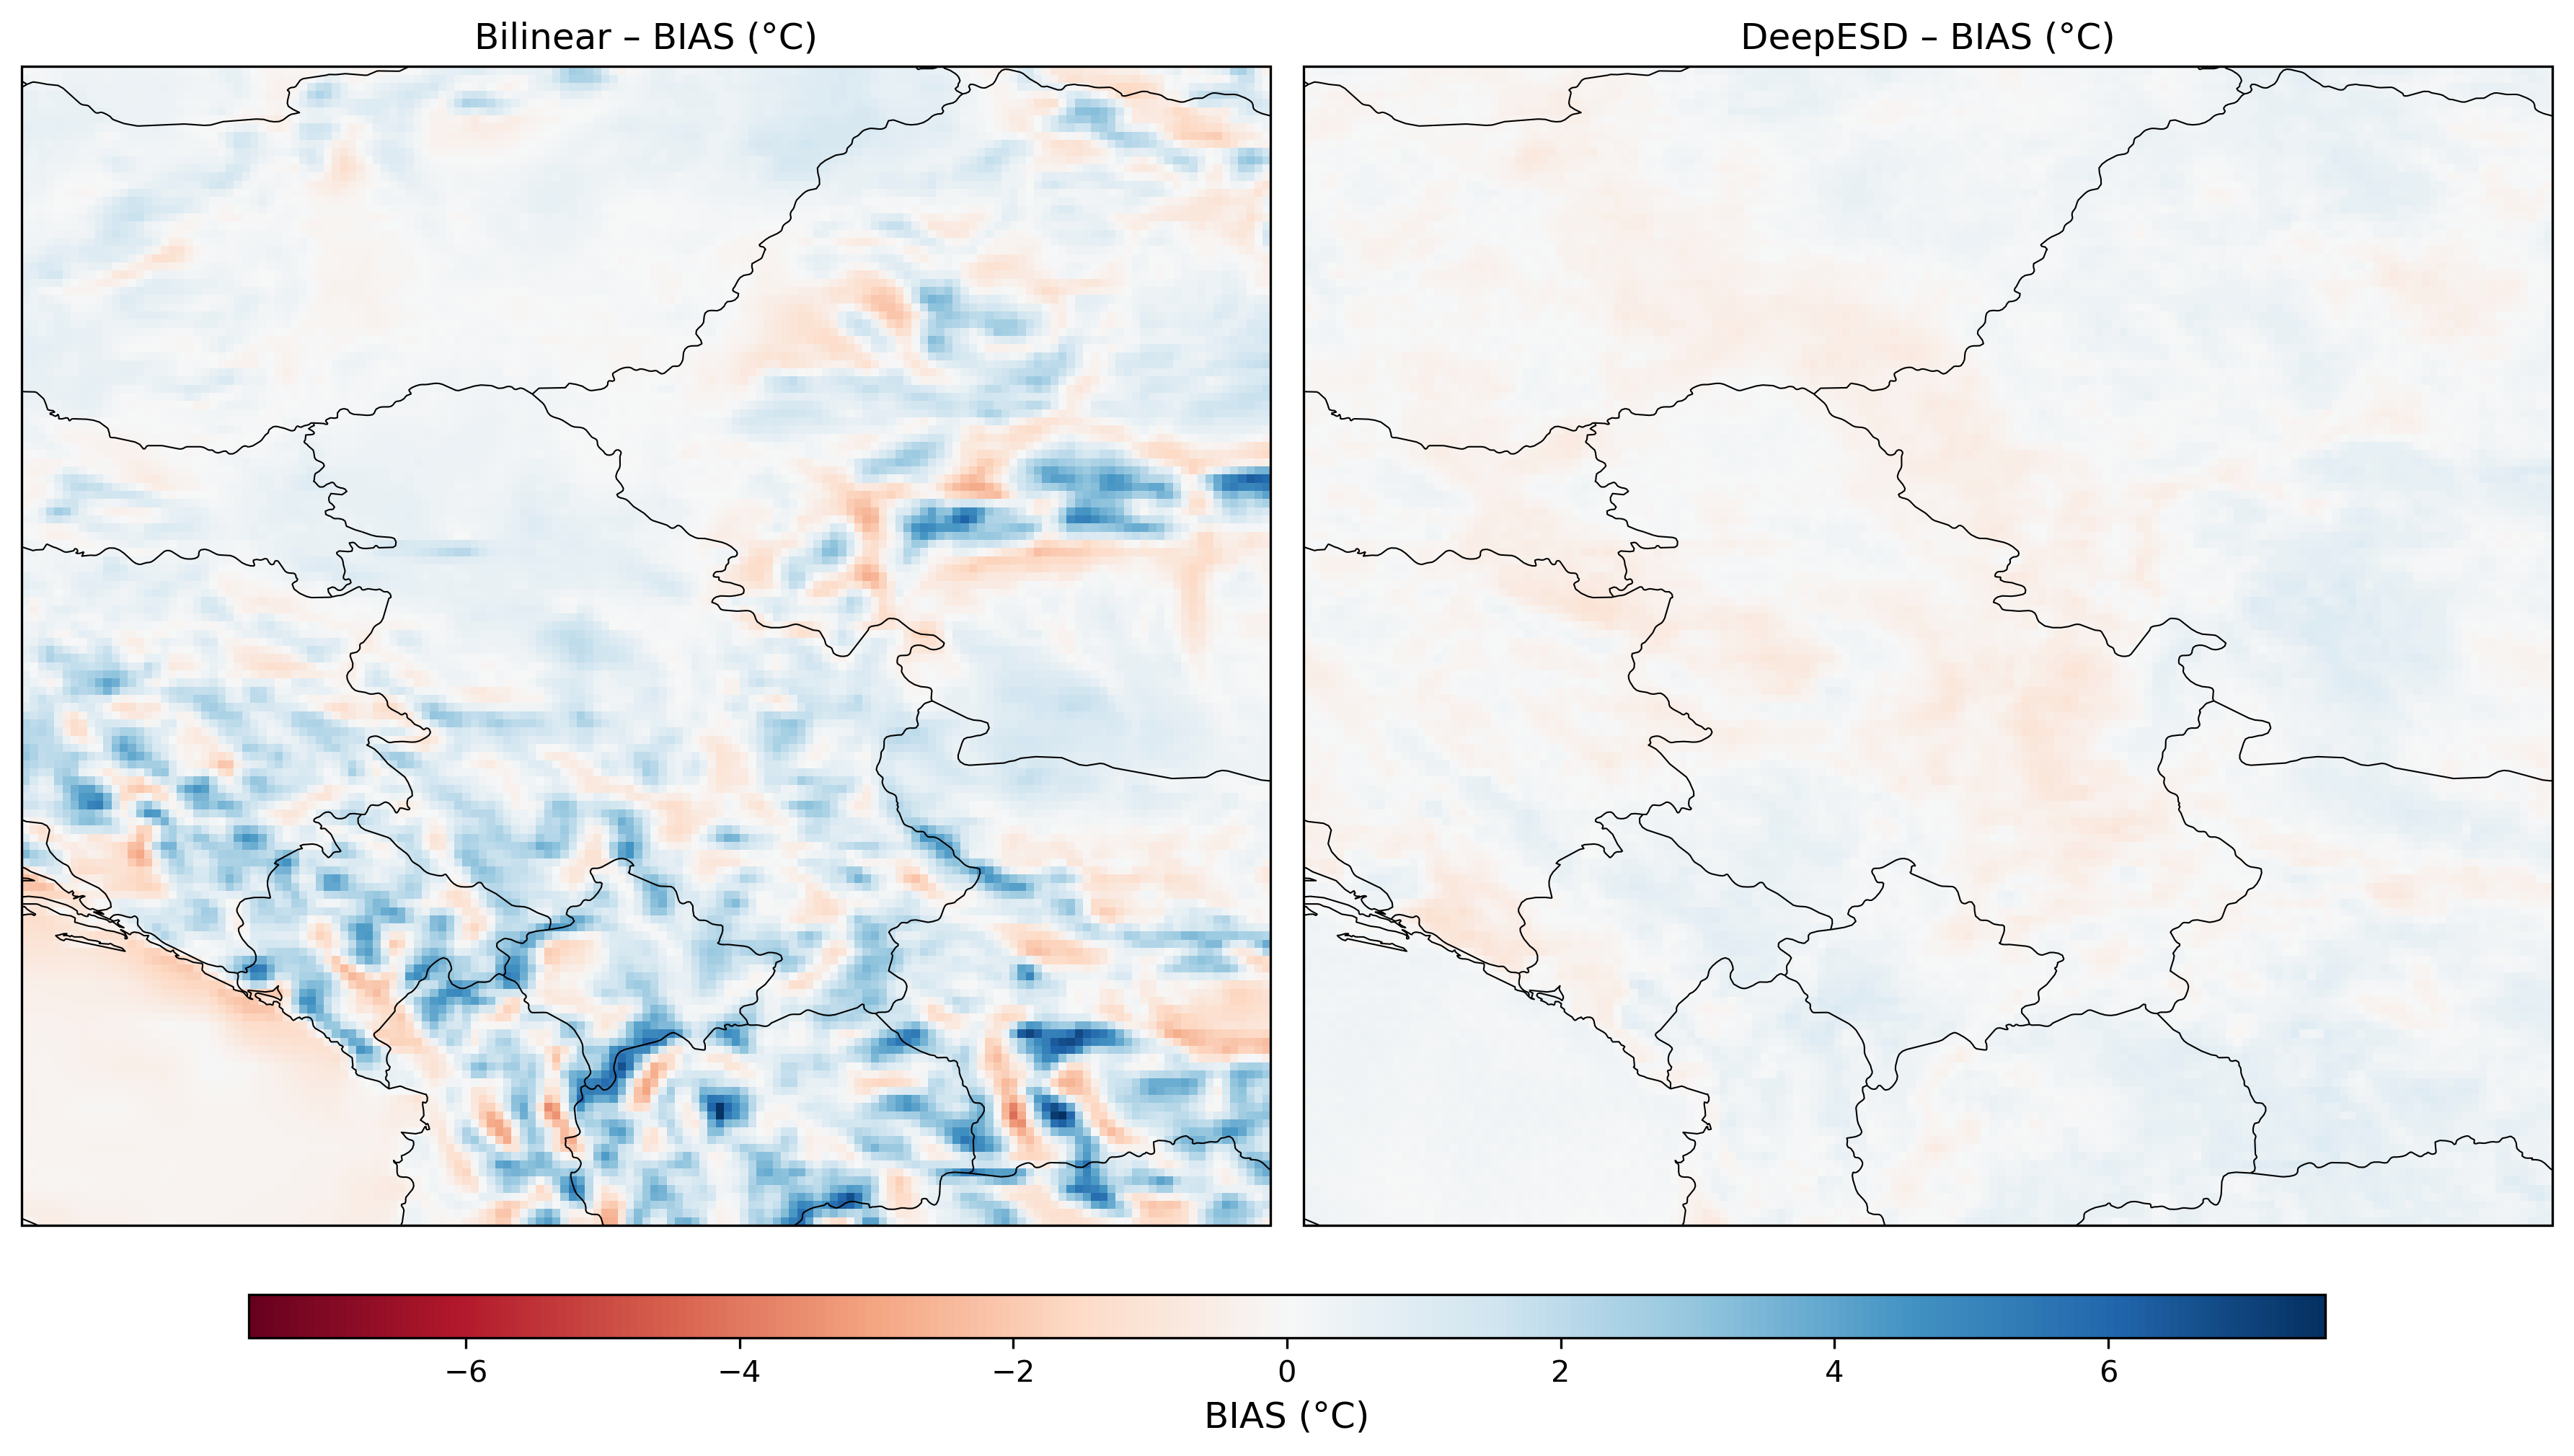

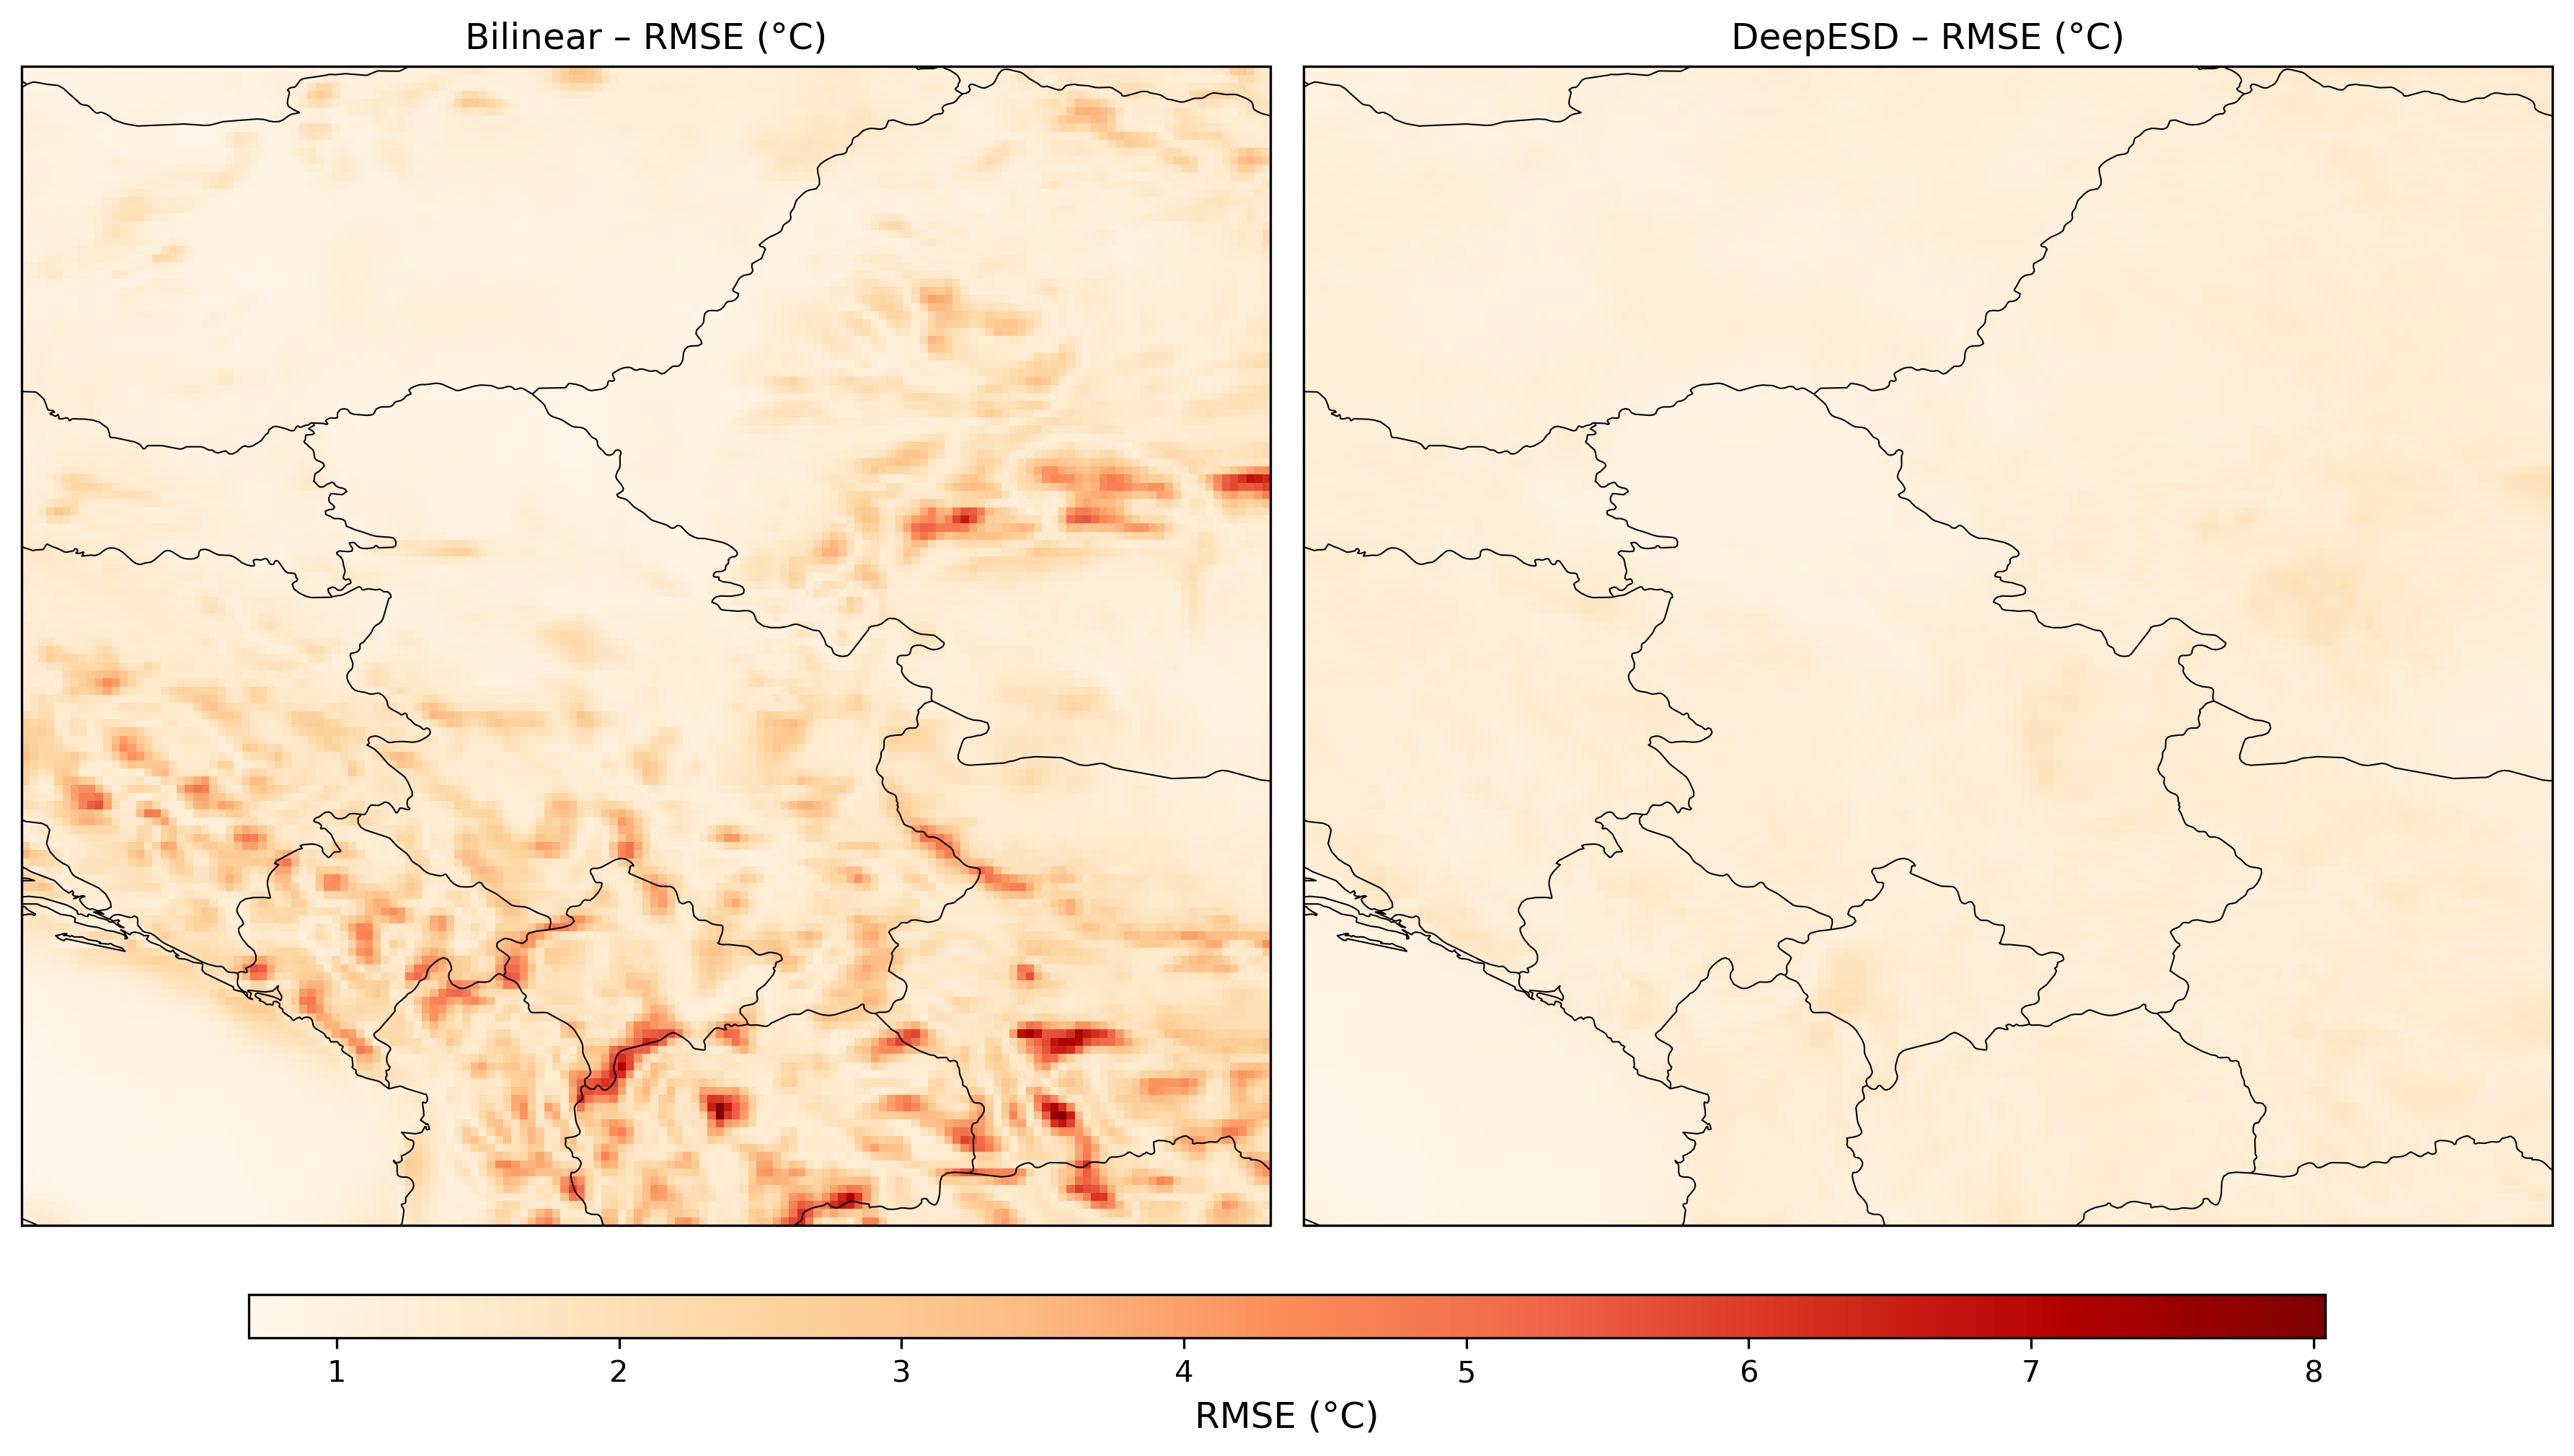

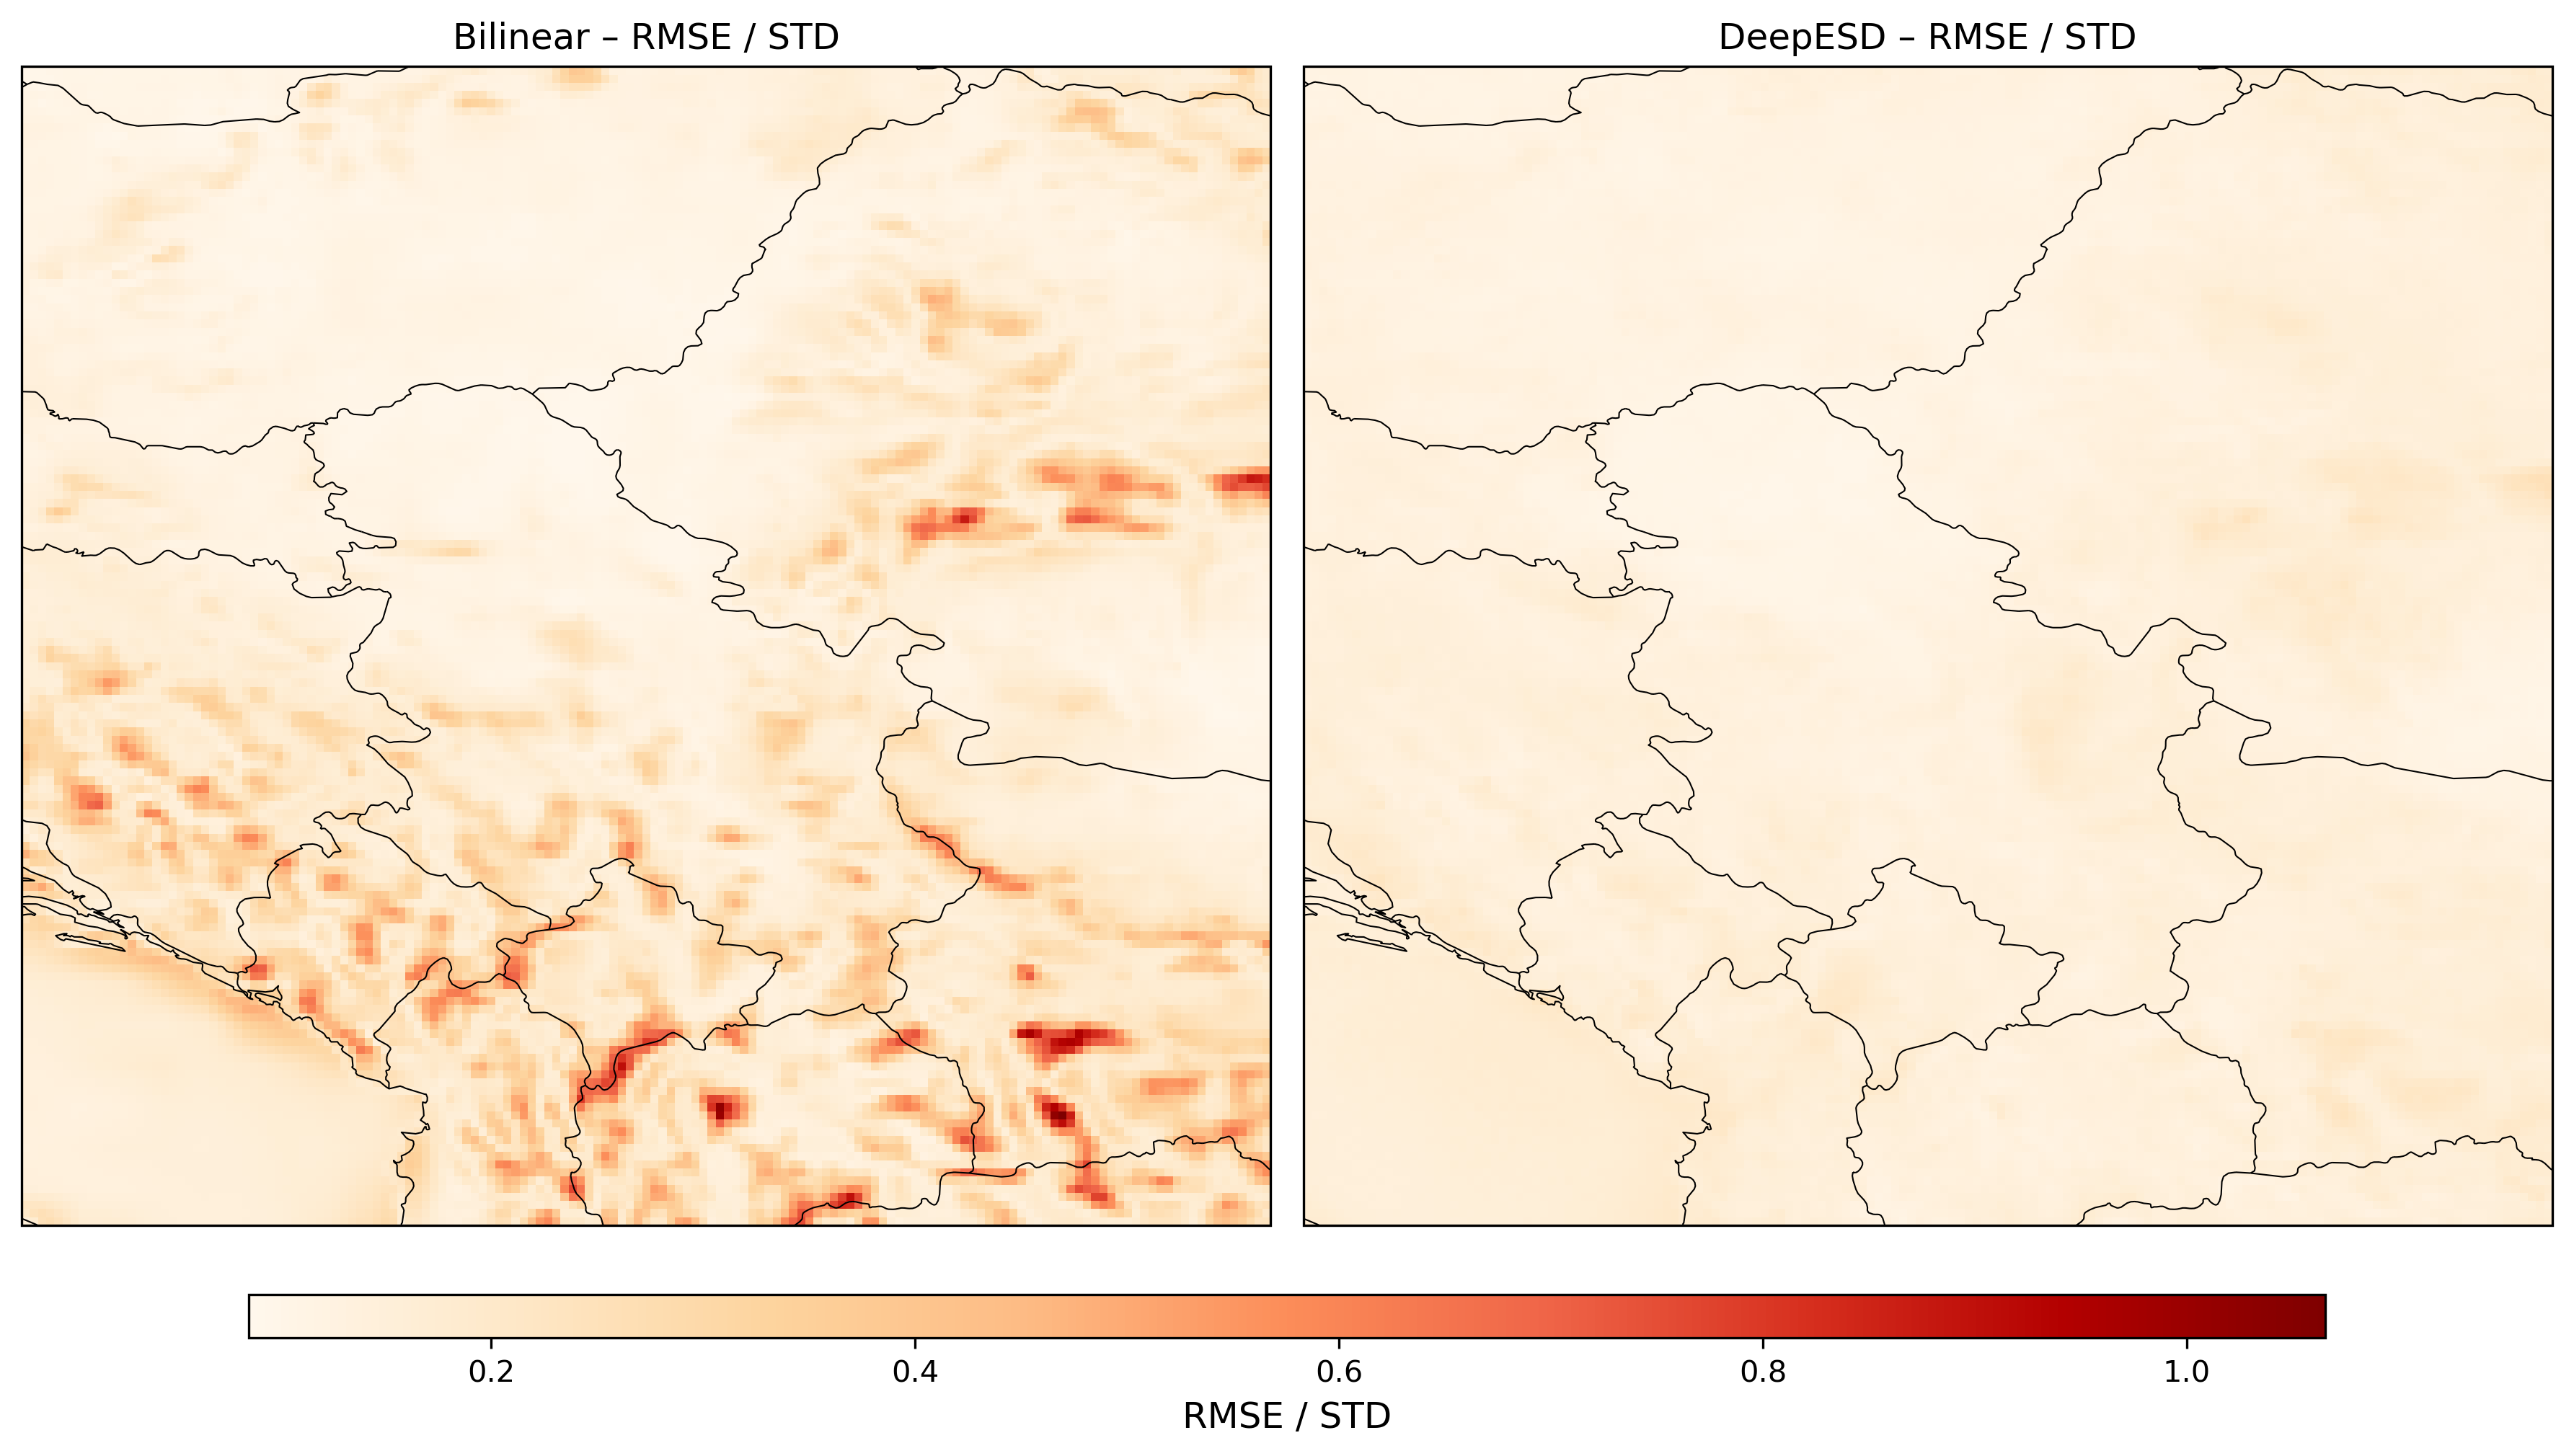

In [52]:
# Display them inline
display(Image(f"{metrics_dir}/bias_comparison.png"))
display(Image(f"{metrics_dir}/rmse_comparison.png"))
display(Image(f"{metrics_dir}/rmse_std_comparison.png"))